In [1]:
import sys 
sys.path.append("..") 

#from topological_models import generator
import numpy as np
import numpy.linalg as LA
import scipy.linalg as sLA

from topology_model import NonHermitianHamiltonian, NonHermitianTopologicalModel
import matplotlib.pyplot as plt
from machine_learning import Cluster
from machine_learning import Classifier
from topology_model import sigma_0, sigma_x, sigma_y, sigma_z
from topology_model import Generator
from topology_model import topology_comparator, topology_verifier, obtain_phase_center_and_number

In [24]:
class LossTopology3D(NonHermitianHamiltonian):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()

        self.initiate()

    def get_Hamiltonian_background(self, k):
        n = self.get_n()
        #kx, ky, kz = k
        t0, _, _ = self.parameters
        hamiltonian = np.zeros((n,n),dtype=complex)

        couplings = [
            [1, 3, [0,0,0], t0], [1, 3, [1,0,0], t0],
            [1, 4, [0,0,0], t0], [1, 4, [0,1,0], t0],
            [1, 5, [0,0,0], t0], [1, 5, [0,0,1], t0],
            [2, 3, [0,0,0], -t0], [3, 2, [0,1,0], -t0],
            [2, 4, [0,0,0], t0], [4, 2, [1,0,0], t0],
            [2, 6, [0,0,0], t0], [2, 6, [0,0,1], t0],
            [3, 7, [0,0,0], t0], [3, 7, [0,0,1], t0],
            [4, 8, [0,0,0], t0], [4, 8, [0,0,1], t0],
            [5, 7, [0,0,0], -t0], [5, 7, [1,0,0], -t0],
            [5, 8, [0,0,0], -t0], [5, 8, [0,1,0], -t0],
            [6, 7, [0,0,0], t0], [7, 6, [0,1,0], t0],
            [6, 8, [0,0,0], -t0], [8, 6, [1,0,0], -t0]
        ]

        # t1 = (1 + 1e-4*np.random.random())*t0
        # couplings = [
        #     [1, 3, [0,0,0], t0], [1, 3, [1,0,0], t1],
        #     [1, 4, [0,0,0], t0], [1, 4, [0,1,0], t1],
        #     [1, 5, [0,0,0], t0], [1, 5, [0,0,1], t1],
        #     [2, 3, [0,0,0], -t0], [3, 2, [0,1,0], -t1],
        #     [2, 4, [0,0,0], t0], [4, 2, [1,0,0], t1],
        #     [2, 6, [0,0,0], t0], [2, 6, [0,0,1], t1],
        #     [3, 7, [0,0,0], t0], [3, 7, [0,0,1], t1],
        #     [4, 8, [0,0,0], t0], [4, 8, [0,0,1], t1],
        #     [5, 7, [0,0,0], -t0], [5, 7, [1,0,0], -t1],
        #     [5, 8, [0,0,0], -t0], [5, 8, [0,1,0], -t1],
        #     [6, 7, [0,0,0], t0], [7, 6, [0,1,0], t1],
        #     [6, 8, [0,0,0], -t0], [8, 6, [1,0,0], -t1]
        # ]

        Nx, Ny, Nz = 2, 2, 2

        for ix in range(Nx):
            for iy in range(Ny):
                for iz in range(Nz):
                    for coupling in couplings:        
                        i, j, R, c = coupling
                        index = (i-1) + np.array([8, 8*Nx, 8*Nx*Ny]) @ np.array([ix, iy, iz])
                        indexp = (j-1) + np.array([8, 8*Nx, 8*Nx*Ny]) @ np.array([(ix + R[0])%Nx, (iy + R[1])%Ny, (iz + R[2])%Nz])

                        if (((ix + R[0]) < Nx) and ((iy + R[1]) < Ny) and ((iz + R[2]) < Nz)):
                            hamiltonian[index, indexp] = hamiltonian[index, indexp] + c
                            hamiltonian[indexp, index] = hamiltonian[indexp, index] + np.conjugate(c)
                        else:
                            hamiltonian[index, indexp] = hamiltonian[index, indexp] + c*np.exp(1j*(k @ np.array(R)))
                            hamiltonian[indexp, index] = hamiltonian[indexp, index] + np.conjugate(c*np.exp(1j*(k @ np.array(R))))

        return hamiltonian

    def get_n(self):
        '''
        n*n Hamiltonian
        '''
        return 8*2*2*2 #64 sites

    def get_n_dim(self):
        return 3

    def get_parameters(self):
        return self.parameters

    def set_parameters(self, **kwargs):
        self.parameters = kwargs['t0'], kwargs['g1'], kwargs['g2']

    def get_kpoints(self, n_points=2):    
        # kpoints = list()
        # for kx in np.linspace(-np.pi,np.pi,n_points):
        #     for ky in np.linspace(-np.pi,np.pi,n_points):
        #         for kz in np.linspace(-np.pi,np.pi,n_points):
        #             kpoints.append([kx, ky, kz])
        kpoints = [ik*np.array([0,np.pi,0]) + np.array([0,0,0]) for ik in np.arange(0, 1, 1/n_points)]
        kpoints += [ik*np.array([np.pi,0,0]) + np.array([0,np.pi,0]) for ik in np.arange(0, 1, 1/n_points)]
        kpoints += [ik*np.array([-np.pi,-np.pi,0]) + np.array([np.pi,np.pi,0]) for ik in np.arange(0, 1, 1/n_points)]
        kpoints += [ik*np.array([np.pi,np.pi,np.pi]) + np.array([0,0,0]) for ik in np.arange(0, 1, 1/n_points)]
        kpoints += [ik*np.array([0,0,np.pi]) + np.array([np.pi,np.pi,np.pi]) for ik in np.arange(0, 1+1/n_points, 1/n_points)]

        #kpoints = [np.array([0,0,0])]
        return kpoints

    def initiate(self):
        t0 = 1.
        g1 = -3 + 6*np.random.random()
        g2 = -3 + 6*np.random.random()
        self.parameters = t0, g1, g2

    def is_real_line_gap(self):
        kpoints = self.get_kpoints()
        for kpoint in kpoints:
            hk = self.get_Hamiltonian(kpoint)
            Es = LA.eigvals(hk)
            if np.any(np.abs(np.real(Es)) < 1e-3):
                return False
        return True  
    
    def is_imaginary_line_gap(self):
        return not self.is_real_line_gap()
    
    def get_Hamiltonian(self, k):
        #kx, ky, kz = k
        #hk = np.zeros((4,4), dtype=complex)
        _, g1, g2 = self.parameters
        h0 = self.get_Hamiltonian_background(k)

        n = self.get_n()
        gamma = np.zeros((n, n), dtype=complex)

        Nx, Ny, Nz = 2, 2, 2
        onsiteloss = [
            [1, g1], [2, g1], [3, g2], [4, g2],
            [5, g2], [6, g2], [7, g1], [8, g1]
        ]
        for ix in range(Nx):
            for iy in range(Ny):
                for iz in range(Nz):
                    for ip in range(8):
                        i, g = onsiteloss[ip]
                        index = (i-1) + np.array([8, 8*Nx, 8*Nx*Ny]) @ np.array([ix, iy, iz])
                        gamma[index, index] = 1j*g*((-1)**(ix+iy+iz))

        hk =  h0 + gamma 

        hk = hk - self.E_ref*np.identity(n)

        return hk
    
class LossTopology3DPerturbation(LossTopology3D):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()
        self.initiate()

    def initiate(self):
        # different parameter region for the different gap type
        t0 = -1 + 2*np.random.random()
        g1 = -1 + 2*np.random.random()
        g2 = -1 + 2*np.random.random()
        self.parameters = t0, g1, g2
    
    def get_Hamiltonian(self, k):
        hk = super().get_Hamiltonian(k)
        hk = hk*0.05
        return hk

Number of samples:  500


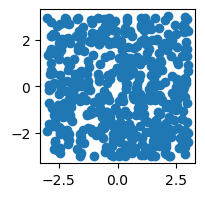

In [27]:
gap_type="real line"
E_ref = 0.
hamiltonian_model = LossTopology3D(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_model, gap_type=gap_type)

n_sample = 500
_models, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

models = list()
for model in _models:
    if model.is_real_line_gap():
        models.append(model)

print("Number of samples: ", len(models))

gs = np.zeros((len(models),2))
for im in range(len(models)):
    _, g1, g2 = models[im].get_parameters()
    gs[im] = g1, g2

plt.figure(figsize=(2,2))
plt.scatter(gs[:,0],gs[:,1])
plt.show()

In [28]:
def sfunc(Q1, Q2, c_val=-10):
    n_k = len(Q1)
    for i in range(n_k):
        _Q = Q1[i]+Q2[i]
        #print(np.log10(np.abs(np.linalg.eigvalsh(_Q))))
        for v in np.real(np.linalg.eigvals(_Q)):
            if np.log10(np.abs(v)) < c_val:
                return 0    # has a cross
    return 1

def fast_topology_comparator(topological_model1, topological_model2, kpoints, perturbation=None):
    '''
    Compare two topological models, return the similiarity
    '''
    for k in kpoints:
        Q1 = topological_model1.calculate_Q(kpoints=[k], perturbation=perturbation)
        Q2 = topological_model2.calculate_Q(kpoints=[k], perturbation=perturbation)
        if sfunc(Q1, Q2) == 0:
            return 0

    return 1

In [29]:
from functools import partial
similarity_func = partial(fast_topology_comparator, kpoints=[[0,0,0]])
cluster = Cluster(similarity_function=similarity_func, verbose=True)
center_indices, group_number = cluster.fit(models)
print(center_indices)
print(group_number)
print("The number of centers: ", len(center_indices))

Start to cluster data by my own method with the size as [500] with sc = 0.5.
Clustering ... 
A sample with new topological phase detected! [1]
Done. Spend time as [7.669 seconds]
[1 0]
[261 239]
The number of centers:  2


In [33]:
center_models = [models[i] for i in center_indices]

for model in center_models:
    print(model.get_parameters())

E_ref = 0.
hamiltonian_perturbation = LossTopology3DPerturbation(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_perturbation, gap_type=gap_type)

n_sample = 10
perturbations, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

n_center = len(center_models)
similarity_center = np.zeros((n_center, n_center))
for i in range(n_center):
    for j in range(n_center):
        _similarity = 0
        for perturbation in perturbations:
            if (similarity_func(center_models[i], center_models[j], kpoints=[[0,0,0]], perturbation=perturbation) > 0):
                _similarity = 1
        similarity_center[i,j] = _similarity

print(similarity_center)

(1.0, -0.8138007913652663, 0.5361119728671238)
(1.0, 2.2933358677531253, 0.4286827904555661)
[[1. 0.]
 [0. 1.]]


In [39]:
print("Gap type: ", gap_type)
hamiltonian_perturbation = LossTopology3DPerturbation(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_perturbation, gap_type=gap_type)

n_sample = 3
perturbations, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

new_center_indices, new_group_number = obtain_phase_center_and_number(center_indices, group_number, models, perturbations, similarity_func=similarity_func)
print("The number of phases: ", len(new_group_number))
print(new_group_number)

Gap type:  real line
The number of phases:  2
[261, 239]


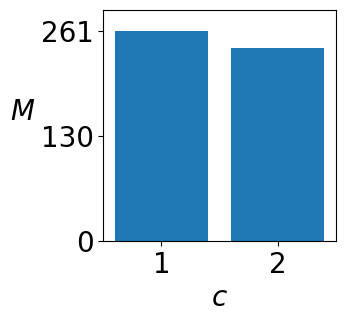

In [40]:
plt.figure(figsize=(3,3))
plt.bar(np.arange(len(new_group_number))+1, new_group_number)
plt.xlim([0.5,len(new_group_number)+0.5])
plt.xticks(list(range(1,len(new_group_number)+1)),fontsize=20)
plt.ylim([0, np.max(new_group_number)*1.1])
plt.yticks([0, int(np.max(new_group_number)/2), int(np.max(new_group_number))],fontsize=20)
plt.xlabel(r"$c$",fontsize=20)
plt.ylabel(r"$M$",fontsize=20,rotation=0,horizontalalignment='right')
plt.show()

In [42]:
classifier = Classifier(similarity_func=similarity_func, cluster_centers=[models[index] for index in center_indices])

n1 = 21
n2 = 21
g1s = np.linspace(-3,3,n1)
g2s = np.linspace(-3,3,n2)

v_list = np.zeros((n1,n2))

for i in range(n1):
    for j in range(n2):
        hamiltonian = LossTopology3D(E_ref=E_ref)
        hamiltonian.set_parameters(t0=1, g1=g1s[i], g2=g2s[j])
        #print(hamiltonian.get_parameters())
        if hamiltonian.is_real_line_gap():
            _model = NonHermitianTopologicalModel(hamiltonian=hamiltonian, gap_type="real line")
            v_list[i,j] = classifier.classify(_model)

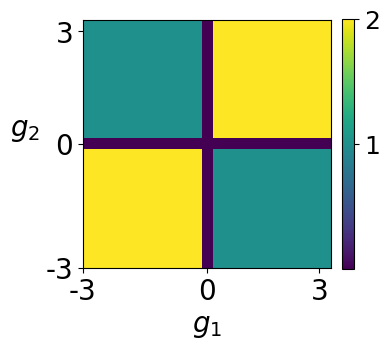

In [43]:
n1, n2 = v_list.shape

plt.figure(figsize=(4,4))
plt.imshow(np.transpose(v_list), origin='lower',extent = [0,n1,0,n2])
plt.xlabel(r"$g_1$",fontsize=20)
plt.ylabel(r"$g_2$",fontsize=20, rotation=0, horizontalalignment='right')
plt.xticks([0, n1/2, n1-1],[r"-3", r"0", r"3"],fontsize=20)
plt.yticks([0, n2/2, n2-1],[r"-3", r"0", r"3"], fontsize=20)

cb = plt.colorbar(ticks=range(1, len(center_indices)+1), fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()

# Save data

In [44]:
from tools import save_data, save_data_M

name = "3D_loss_topology"
save_data(new_center_indices, new_group_number, "figs_{0}_group_number.h5".format(name))
save_data_M(v_list, "figs_{0}_phase_diagram.h5".format(name))
print(name)

3D_loss_topology
